# Experiment 1: Synthetic data
This notebook compares the accuracy and the wall clock time for various GP ensemble methods

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import time

from guepard.utilities import get_gpr_submodels

rng = np.random.RandomState(123)
tf.random.set_seed(42)

d = 3                   # input space dimension
n = 50 * 4**d           # number of observation points
p = 4**d                # number of submodels

print(f"n = {n}, d = {d}")

kernel = gpflow.kernels.Matern52(lengthscales=[0.25]*d)
noise_var = 1e-2

lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(noise_var)

mean_function = gpflow.mean_functions.Zero()

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));


/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


n = 3200, d = 3


/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We generate samples from the prior distribution as test function.


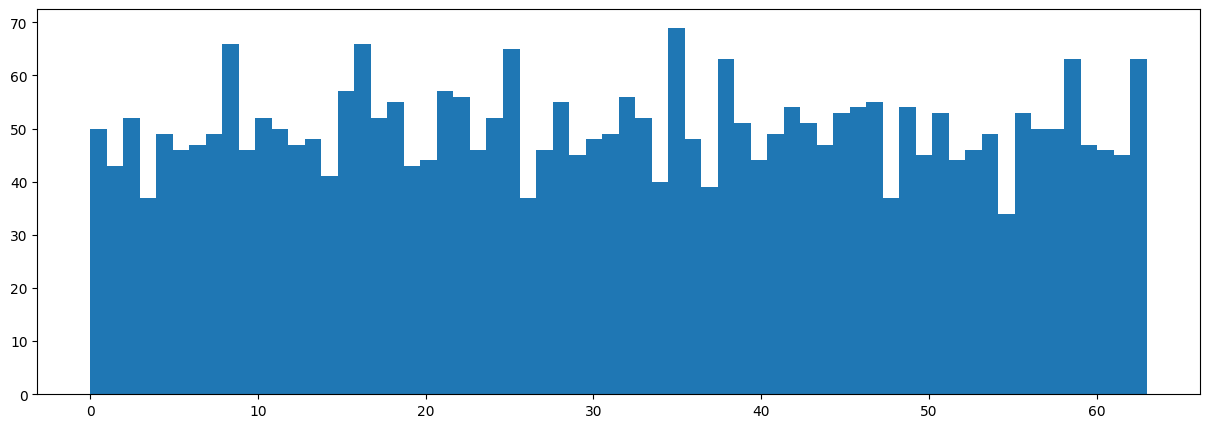

In [2]:
def make_data(n_train, n_test, d):

    n = n_train + n_test
    X = np.random.uniform(size=(n, d))
    Y = np.empty((n, 1))

    dummy_data = np.array([[100.]]*d).T, np.array([[0.]])
    F = gpflow.models.GPR(dummy_data, kernel).predict_f_samples(X, 1).numpy()[0]
    Y = F + np.random.normal(0, np.sqrt(noise_var), size=F.shape)
    return X[:n_train, :], Y[:n_train, :], X[n_train:, :], Y[n_train:, :]

def get_subgroup(X):
    d = X.shape[1]
    z = np.linspace(1/8, 7/8, 4)
    Z = np.meshgrid(*([z]*d))
    Z = np.array([z.flatten() for z in Z]).T

    D2 = np.sum((X[:, None, :] - Z[None, :, :])**2, axis=-1)

    ind = np.argmin(D2, axis=1)
    return(ind)

X, Y, Xtest, Ytest = make_data(n, 100, d)
ind = get_subgroup(X)

plt.figure(figsize=(15, 5))
plt.hist(ind, bins=p);



In [3]:
datasets = [(X[ind==i, :], Y[ind==i, :]) for i in range(p)]

start_time = time.time()
submodels = get_gpr_submodels(datasets, kernel, mean_function=mean_function, noise_variance=noise_var) # list of GPR models
wct = time.time() - start_time
wct

0.19150280952453613

In [9]:
start_time = time.time()
m_nested = guepard.baselines.NestedGP(submodels)
mean, var = m_nested.predict_f(Xtest)
wct = time.time() - start_time

NLPD = -np.mean(m_nested.predict_log_density((Xtest, Ytest)))

print(f"NLPD: {NLPD}, time: {wct}")

NLPD: -0.7280616370738724, time: 1.1546740531921387


In [10]:
start_time = time.time()
m_poe = guepard.baselines.Ensemble(submodels, "PoE", weighting="NoWeights")
mean, var = m_poe.predict_f(Xtest)
wct = time.time() - start_time
wct

NLPD = -np.mean(m_poe.predict_log_density((Xtest, Ytest)))

print(f"NLPD: {NLPD}, time: {wct}")


WeightingMethods.VAR
WeightingMethods.VAR
NLPD: 1.8151292674398305, time: 0.40253305435180664


In [11]:
start_time = time.time()
m_guepard = guepard.EquivalentObsEnsemble(submodels)
mean, var = m_guepard.predict_f(Xtest)
wct = time.time() - start_time
NLPD = -np.mean(m_guepard.predict_log_density((Xtest, Ytest)))

print(f"NLPD: {NLPD}, time: {wct}")

NLPD: -0.6865378867581071, time: 0.478790283203125
